In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [3]:
np.random.seed(1)
N=100
K=3
T3 = np.zeros((N,3),dtype=np.uint8)
X = np.zeros((N,2))
X_range0 = [-3,3]
X_range1 = [-3,3]
X_col = ['blue','black','white']
Mu = np.array([[-.5,-.5],[.5,1.0],[1,-.5]])#분포의 중심
Sig = np.array([[.7,.7],[.8,.3],[.3,.8]])#분포의 분산
Pi = np.array([0.4,0.8,1])#누적확률

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n,k] = 1
            break
    for k in range(2):
        X[n,k] = (np.random.randn() * Sig[T3[n,:] == 1,k] + Mu[T3[n,:] == 1,k])


In [4]:
def show_data(x):
    plt.plot(x[:,0],x[:,1],linestyle='none', marker='o',markersize=6,
            markeredgecolor='black',color='gray',alpha=0.8)
    plt.grid(True)

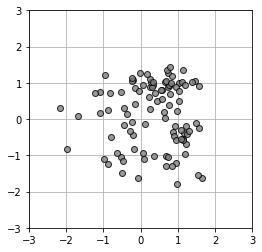

In [5]:
plt.figure(1,figsize=(4,4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz',X=X,X_range0=X_range0,X_range1=X_range1)

In [6]:
#Mu 와 r 초기화
Mu = np.array([[-2,1],[-2,0],[-2,-1]])
R = np.c_[np.ones((N,1),dtype=int),np.zeros((N,2),dtype=int)]

In [7]:
def show_prm(x,r,mu,col):
    for k in range(K):
        plt.plot(x[r[:,k]==1,0],x[r[:,k]==1,1],marker='o',markerfacecolor=X_col[k],markeredgecolor='k'
            ,markersize=6 ,alpha =0.5,linestyle='none')
        plt.plot(mu[k,0],mu[k,1],marker='*',
                markerfacecolor=X_col[k],markersize=15,
                markeredgecolor='k',markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)

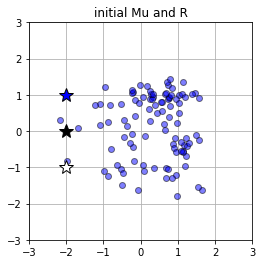

In [8]:
plt.figure(figsize=(4,4))
R=np.c_[np.ones((N,1)),np.zeros((N,2))]
show_prm(X,R,Mu,X_col)
plt.title('initial Mu and R')
plt.show()

In [9]:
#r을 정한다
def step1_kmeans(x0,x1,mu):
    N=len(x0)
    r= np.zeros((N,K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n]-mu[k,0])**2 + (x1[n]-mu[k,1])**2
        r[n,np.argmin(wk)]=1
    return r

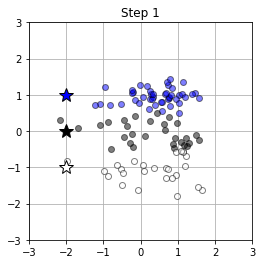

In [10]:
plt.figure(figsize=(4,4))
R = step1_kmeans(X[:,0],X[:,1],Mu)
show_prm(X,R,Mu,X_col)
plt.title('Step 1')
plt.show()

In [11]:
def step2_kmeans(x0,x1,r): #최적의 Mu 찾기
    mu = np.zeros((K,2))
    for k in range(K):
        mu[k,0] = np.sum(r[:,k]*x0) / np.sum(r[:,k])
        mu[k,1] = np.sum(r[:,k]*x1) / np.sum(r[:,k])
    return mu

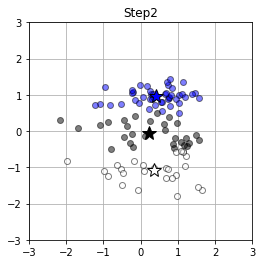

In [12]:
plt.figure(figsize=(4,4))
Mu = step2_kmeans(X[:,0],X[:,1],R)
show_prm(X,R,Mu,X_col)
plt.title('Step2')
plt.show()

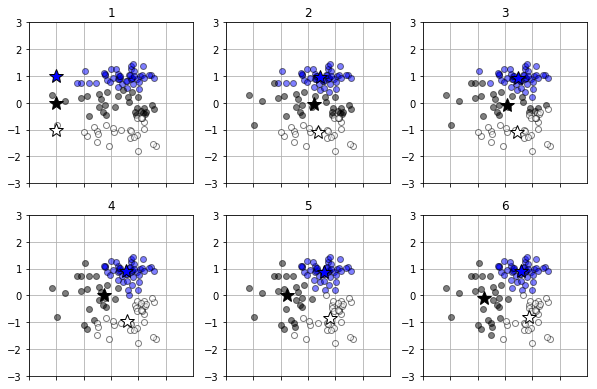

In [13]:
plt.figure(1,figsize=(10,6.5))
Mu=np.array([[-2,1],[-2,0],[-2,-1]])
max_it = 6 #반복 횟수
for it in range(0,max_it):
    plt.subplot(2,3,it+1)
    R =step1_kmeans(X[:,0],X[:,1],Mu)
    show_prm(X,R,Mu,X_col)
    plt.title("{0:d}".format(it+1))
    plt.xticks(range(X_range0[0],X_range0[1]),"")
    plt.xticks(range(X_range1[0],X_range1[1]),"")
    Mu = step2_kmeans(X[:,0],X[:,1],R)
plt.show()

왜곡척도

In [22]:
def distortion_measure(x0,x1,r,mu):
    N=len(x0)
    J=0
    for n in range(N):
        for k in range(K):
            J = J+r[n,k] * ((x0[n]-mu[k,0])**2
                           + (x1[n] - mu[k,1])**2)
    return J

In [23]:
Mu = np.array([[-2,1],[-2,0],[-2,-1]])
R = np.c_[np.ones((N,1),dtype=int),np.zeros((N,2),dtype=int)]
distortion_measure(X[:,0],X[:,1],R,Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


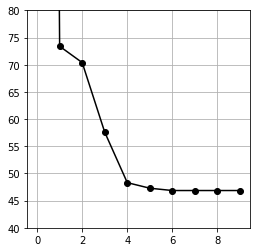

In [25]:
#Mu와 R의 초기화
N=X.shape[0]
K=3
Mu=np.array([[-2,1],[-2,0],[-2,-1]])
R=np.c_[np.ones((N,1),dtype=int),np.zeros((N,2),dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) #왜곡  척도의 계산 결과를 넣는다
for it in range(0,max_it):
    R = step1_kmeans(X[:,0],X[:,1],Mu)
    DM[it] = distortion_measure(X[:,0],X[:,1],R,Mu)#왜곡 척도
    Mu = step2_kmeans(X[:,0],X[:,1],R)
print(np.round(DM,2))
plt.figure(2,figsize=(4,4))
plt.plot(DM,color='black',linestyle='-',marker='o')
plt.ylim(40,80)
plt.grid(True)
plt.show()

## GMM(gaussian mixture model)

In [26]:
def gauss(x,mu,sigma):
    N,D = x.shape
    c1 = 1/(2*np.pi)**(D/2)
    c2 = 1/(np.linalg.det(sigma)**(1/2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x-mu
    c4 = np.dot(c3,inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5+c4[:,d] * c3[:,d]
    p=c1 * c2* np.exp(-c5/2)
    return p

In [27]:
x = np.array([[1,2],[2,1],[3,4]])
mu = np.array([1,2])
sigma = np.array([[1,0],[0,1]])
print(gauss(x,mu,sigma))

[0.15915494 0.05854983 0.00291502]


In [28]:
def mixgauss(x,pi,mu,sigma):
    N,D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p+ pi[k]*gauss(x,mu[k,:],sigma[k,:,:])
    return p

In [29]:
x = np.array([[1,2],[2,2],[3,4]])
pi = np.array([0.3,0.7])
mu = np.array([[1,1],[2,2]])
sigma = np.array([[[1,0],[0,1]],[[2,0],[0,1]]])
print(mixgauss(x,pi,mu,sigma))

[0.09031182 0.09634263 0.00837489]


## plot

In [34]:
#혼합 가우스 등고선 표시
def show_contour_mixgauss(pi,mu,sigma):
    xn = 40
    x0 = np.linspace(X_range0[0],X_range0[1],xn)
    x1 = np.linspace(X_range1[0],X_range1[1],xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0,xn*xn,1),np.reshape(xx1,xn*xn,1)]
    f = mixgauss(x,pi,mu,sigma)
    print(f)
    f = f.reshape(xn,xn)
    f = f.T
    plt.contour(x0,x1,f,10,colors='gray')

In [41]:
def show3d_mixgauss(ax,pi,mu,sigma):
    xn = 40
    x0 = np.linspace(X_range0[0],X_range0[1],xn)
    x1 = np.linspace(X_range1[0],X_range1[1],xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0,xn*xn,1),np.reshape(xx1,xn*xn,1)]
    f = mixgauss(x,pi,mu,sigma)
    f = f.reshape(xn,xn)
    f = f.T
    ax.plot_surface(xx0,xx1,f,rstride=2,cstride=2,alpha=0.3,color='blue',edgecolor='black')

[0.00861572 0.0114457  0.01450227 ... 0.00078421 0.00045841 0.00025609]


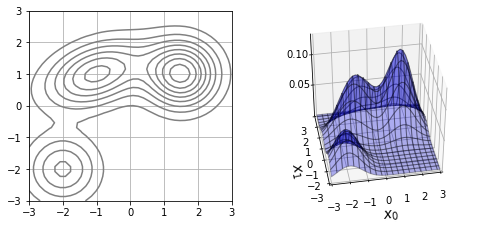

In [42]:
pi = np.array([0.2,0.4,0.4])
mu = np.array([[-2,-2,],[-1,1],[1.5,1]])
sigma = np.array([[[.5,0],[0,.5]],[[1,0.25],[0.25,.5]],[[.5,0],[0,.5]]])

Fig = plt.figure(1,figsize=(8,3.5))
Fig.add_subplot(1,2,1)
show_contour_mixgauss(pi,mu,sigma)
plt.grid(True)

Ax = Fig.add_subplot(1,2,2,projection='3d')
show3d_mixgauss(Ax,pi,mu,sigma)
Ax.set_zticks([0.05,0.10])
Ax.set_xlabel('$x_0$',fontsize=14)
Ax.set_ylabel('$x_1$',fontsize=14)
Ax.view_init(40,-100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()


In [39]:
add_subplot

Object `plt.add_subplot` not found.
